In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv
/kaggle/input/selected-features/feature_selection_9.csv
/kaggle/input/selected-features/feature_selection_10.csv
/kaggle/input/selected-features/feature_selection_5.csv
/kaggle/input/selected-features/feature_selection_8.csv
/kaggle/input/selected-features/feature_selection_2.csv
/kaggle/input/selected-features/feature_selection_6.csv
/kaggle/input/selected-features/feature_selection_7.csv
/kaggle/input/selected-features/feature_selection_4.csv
/kaggle/input/selected-features/feature_selection_3.csv


# Importing Necessary Packages

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE,ADASYN

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.decomposition import PCA,SparsePCA,TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import RFE,RFECV,VarianceThreshold,SelectPercentile,mutual_info_classif,chi2,SequentialFeatureSelector


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier,XGBRFClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,log_loss,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

# Reading training data

In [3]:
df_ = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
df = df_.copy()

# Handling missing data

In [4]:
missing_df = df.isna().sum(axis=0)
missing_df[missing_df!=0]

Recipe_Review    2
dtype: int64

Recipe Review is missing in 2 rows. Since it is textual data, we will drop the entire rows having these two missing recipe reviews.

In [5]:
df.dropna(axis=0,inplace=True)

# Separating Features from the Label

```Rating``` column is our target variable in this dataset.

In [6]:
features = df.drop("Rating", axis=1)
label = df.Rating
features.shape,label.shape

((13634, 14), (13634,))

# Identifying feature types

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13634 non-null  int64 
 1   RecipeNumber       13634 non-null  int64 
 2   RecipeCode         13634 non-null  int64 
 3   RecipeName         13634 non-null  object
 4   CommentID          13634 non-null  object
 5   UserID             13634 non-null  object
 6   UserName           13634 non-null  object
 7   UserReputation     13634 non-null  int64 
 8   CreationTimestamp  13634 non-null  int64 
 9   ReplyCount         13634 non-null  int64 
 10  ThumbsUpCount      13634 non-null  int64 
 11  ThumbsDownCount    13634 non-null  int64 
 12  BestScore          13634 non-null  int64 
 13  Recipe_Review      13634 non-null  object
dtypes: int64(9), object(5)
memory usage: 1.6+ MB


* Categorical $\rightarrow$ ID, RecipeCode, CommentID, UserID, UserName
* Numerical(discrete) $\rightarrow$ RecipeNumber, UserReputation, CreationTimestamp, ReplyCount, ThumbsUpCount, ThumbsDownCount, BestScore
* Text $\rightarrow$ RecipeName, Recipe_Review 

# Class distribution

There are total 13634 samples and following is the distribution of ratings:
* 5 $\rightarrow$ 10369
* 4 $\rightarrow$ 1241
* 3 $\rightarrow$ 368
* 2 $\rightarrow$ 174
* 1 $\rightarrow$ 210
* 0 $\rightarrow$ 1272

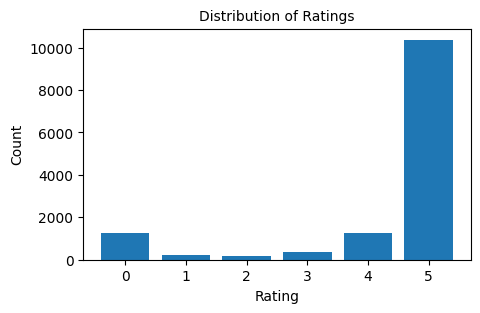

In [8]:
plt.figure(figsize=(5,3))
plt.title("Distribution of Ratings",fontsize=10)
plt.bar(np.arange(6),np.bincount(label),align='center')
plt.xlabel('Rating',fontsize=10)
plt.ylabel('Count',fontsize=10)
plt.xticks(np.arange(6),fontsize=10)
plt.yticks(np.arange(0,10001,2000),fontsize=10)
plt.show()

Clearly the dataset is highly imbalanced.

# Creating Training and validation sets

We will create a 70:30 split for training and validation. Since the data is highly imbalanced, we will create splits in a stratified manner.

In [9]:
Xtrain_,Xtest,ytrain,ytest = train_test_split(features,label,test_size=0.3,random_state=42, stratify=label)
print(Xtrain_.shape, ytrain.shape, Xtest.shape, ytest.shape)

(9543, 14) (9543,) (4091, 14) (4091,)


### Class distribution in training and validation sets

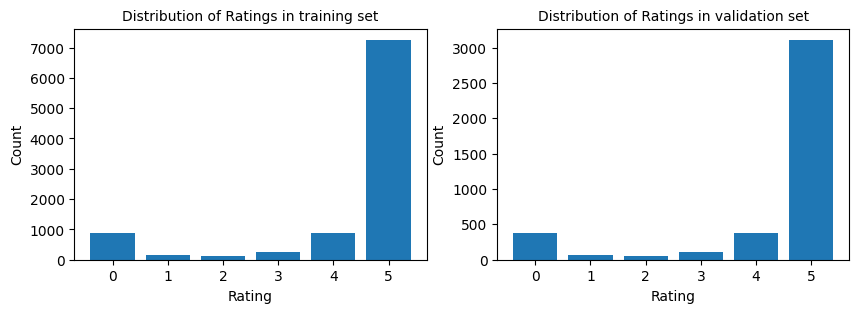

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot the first histogram
axes[0].set_title("Distribution of Ratings in training set",fontsize=10)
axes[0].bar(np.arange(6),np.bincount(ytrain),align='center')
axes[0].set_xlabel('Rating',fontsize=10)
axes[0].set_ylabel('Count',fontsize=10)

# Plot the second histogram
axes[1].set_title("Distribution of Ratings in validation set",fontsize=10)
axes[1].bar(np.arange(6),np.bincount(ytest),align='center')
axes[1].set_xlabel('Rating',fontsize=10)
axes[1].set_ylabel('Count',fontsize=10)

# # Display the figure
plt.show()

# Exploratory Data Analysis

## Outlier Detection

Let's check the presence of outliers among the numerical features.

We'll consider the following features ```UserReputation```, ```ReplyCount```, ```ThumbsUpCount```, ```ThumbsDownCount```, ```BestScore``` .

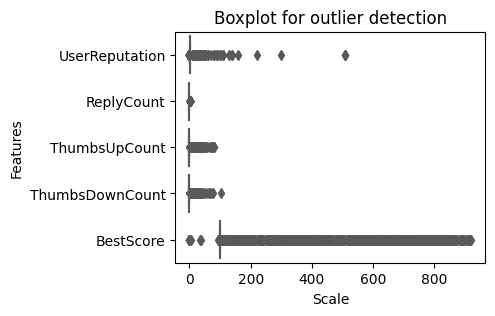

In [11]:
X_num = Xtrain_.iloc[:,[7,9,10,11,12]]
plt.figure(figsize=(4,3))
ax = sns.boxplot(data = X_num, orient="h", palette="Set2")
ax.set(xlabel="Scale", ylabel="Features")
plt.title("Boxplot for outlier detection")
plt.show()

In [12]:
cols = X_num.columns
outliers_df = X_num.describe().T
count= []
lb_ = []
ub_ = []
for col in cols:
    q1 = X_num[col].quantile(0.25)
    q3 = X_num[col].quantile(0.75)
    iqr = q3-q1
    ub = q3+1.5*iqr
    lb = q1-1.5*iqr
    lb_.append(lb)
    ub_.append(ub)
    count.append(X_num[~((X_num[col]>= lb) & (X_num[col] <= ub))].shape[0])
outliers_df["LowerBound"] = lb_
outliers_df["UpperBound"] = ub_
outliers_df["Count of Outliers"] = count
outliers_df

,count,mean,std,min,25%,50%,75%,max,LowerBound,UpperBound,Count of Outliers
UserReputation,9543.0,2.171644,11.299448,0.0,1.0,1.0,1.0,510.0,1.0,1.0,639
ReplyCount,9543.0,0.013727,0.133163,0.0,0.0,0.0,0.0,3.0,0.0,0.0,114
ThumbsUpCount,9543.0,1.087499,4.167348,0.0,0.0,0.0,0.0,80.0,0.0,0.0,2133
ThumbsDownCount,9543.0,0.514408,2.927399,0.0,0.0,0.0,0.0,104.0,0.0,0.0,1269
BestScore,9543.0,152.413602,139.396674,0.0,100.0,100.0,100.0,922.0,100.0,100.0,2180


Since, the number of outliers for each variable is quite high, they may not be outliers.

We won't be considering them outliers for our purpose.

## Relationship among variables

In [13]:
X = Xtrain_.iloc[:,[1,7,9,10,11,12]]
data = X.copy()
data["rating"] = ytrain

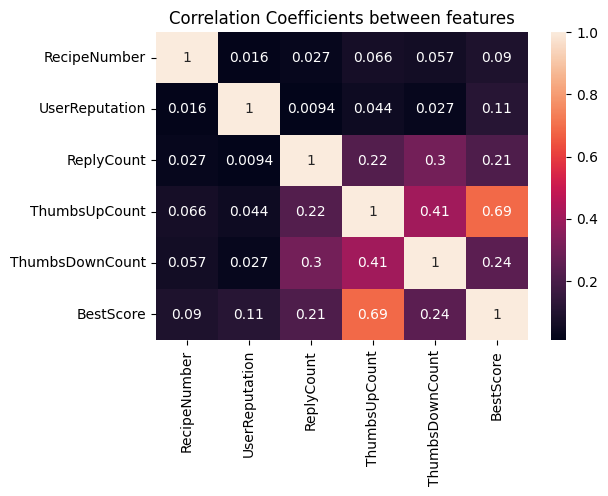

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(X.corr(numeric_only=True),annot=True)
plt.title("Correlation Coefficients between features")
plt.show()

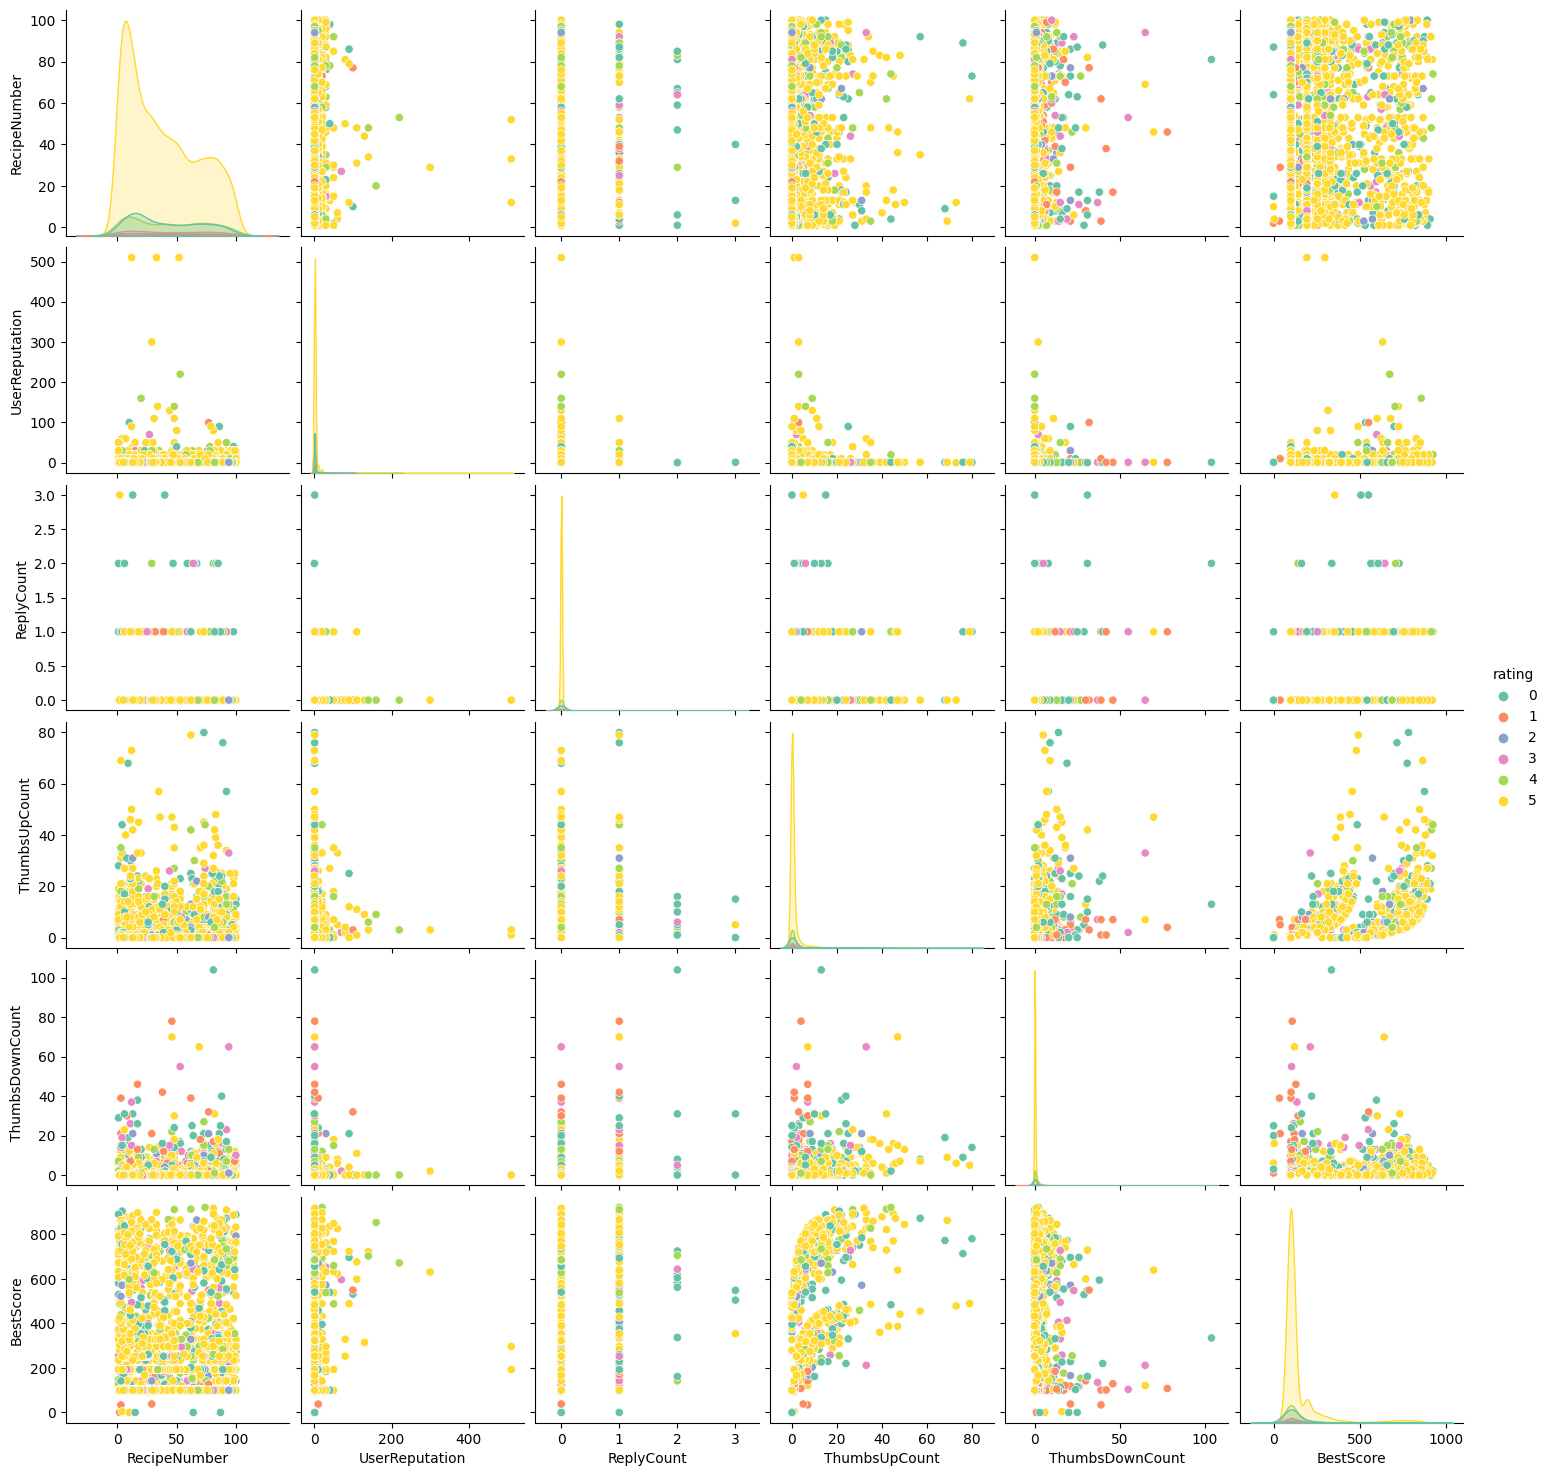

In [15]:
sns.pairplot(data, hue = 'rating',palette='Set2')
plt.show()

# Data Preprocessing

For getting data ready for model training, we'll apply some preprocessing steps as follows:

* Feature Extraction:
    * we will use ```CountVectorizer``` to vectorize the ```UserID``` column with default settings.
    * we will use ```TfidfVectorizer``` to vectorize the ```RecipeName``` and ```Recipe_Review``` column. To filter-out the stop_words, we are setting ```max_df = 0.5``` which will remove the words which occur in more than 50% of the total reviews.


* Scaling:
    * We will scale the features with ```StandardScaler```.


* Feature Selection:
    * We will use ```SelectPercentile``` to select top 40 percentile features based on the ```f_classif``` scoring function.
    * After it, we will recursively eliminate the unnecessary features using ```RFE``` to get the optimum number of features to train our models.
    
We will use ```ColumnTransformer``` and ```Pipeline``` utilities to perform above preprocessing tasks appropriately.

In [16]:
# After performing RFE intesively in multilple steps, we have saved the selected feature indices to save time.
feature_selection_2 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_2.csv").indices)
feature_selection_3 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_3.csv").indices)
feature_selection_4 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_4.csv").indices)
feature_selection_5 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_5.csv").indices)
feature_selection_6 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_6.csv").indices)
feature_selection_7 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_7.csv").indices)
feature_selection_8 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_8.csv").indices)
feature_selection_9 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_9.csv").indices)
feature_selection_10 = list(pd.read_csv("/kaggle/input/selected-features/feature_selection_10.csv").indices)

In [17]:
# Base estimator for RFE
estimator = LGBMClassifier(boosting_type="dart", n_estimators = 200, learning_rate=0.3, subsample=0.9, n_jobs=-1, random_state=42, verbose=-1, verbose_eval=False)

# preprocessing pipeline
feature_extraction = ColumnTransformer([
                                        ("num_columns","passthrough",[9,10,11]),
                                        ("user_id_vec", CountVectorizer(),5),
                                        ("recipe_name_vec", TfidfVectorizer(ngram_range=(1, 1), min_df=1,max_df=0.5),3),
                                        ("recipe_review_vec", TfidfVectorizer(ngram_range=(1, 1), min_df=1,max_df=0.5),13)
                                        ])
preprocessing = Pipeline([("feature_extraction",feature_extraction),
                          ("scaling",StandardScaler(with_mean=False)),
                          ("feature_selection1",SelectPercentile(percentile=40)),
#                           ("feature_selection2",RFE(estimator=estimator, step=100, n_features_to_select=5000)),
                          ("feature_selection_idx2", ColumnTransformer([("select","passthrough",feature_selection_2)])),
#                           ("feature_selection3",RFE(estimator=estimator, step=100, n_features_to_select=4000)),
                          ("feature_selection_idx3", ColumnTransformer([("select","passthrough",feature_selection_3)])),
#                           ("feature_selection4",RFE(estimator=estimator, step=100, n_features_to_select=3000)),
                          ("feature_selection_idx4", ColumnTransformer([("select","passthrough",feature_selection_4)])),
#                           ("feature_selection5",RFE(estimator=estimator, step=100, n_features_to_select=2000)),
                          ("feature_selection_idx5", ColumnTransformer([("select","passthrough",feature_selection_5)])),
#                           ("feature_selection6",RFE(estimator=estimator, step=100, n_features_to_select=1500)),
                          ("feature_selection_idx6", ColumnTransformer([("select","passthrough",feature_selection_6)])),
#                           ("feature_selection7",RFE(estimator=estimator, step=100, n_features_to_select=1300)),
                          ("feature_selection_idx7", ColumnTransformer([("select","passthrough",feature_selection_7)])),
#                           ("feature_selection8",RFE(estimator=estimator, step=100, n_features_to_select=1100)),
                          ("feature_selection_idx8", ColumnTransformer([("select","passthrough",feature_selection_8)])),
#                           ("feature_selection9",RFE(estimator=estimator, step=10, n_features_to_select=1070)),
                          ("feature_selection_idx9", ColumnTransformer([("select","passthrough",feature_selection_9)])),
#                           ("feature_selection10",RFE(estimator=estimator, step=1, n_features_to_select=1069)),
                          ("feature_selection_idx10", ColumnTransformer([("select","passthrough",feature_selection_10)])),
#                           ("densify", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
#                           ("PCA",PCA(n_components=0.95,svd_solver="full"))
                          ])
Xtrain = preprocessing.fit_transform(Xtrain_,ytrain)
Xtrain.shape

(9543, 1069)

In [18]:
# feature_selection_2 = preprocessing[3].get_support(indices=True)
# feature_selection_3 = preprocessing[4].get_support(indices=True)
# feature_selection_4 = preprocessing[5].get_support(indices=True)
# feature_selection_5 = preprocessing[6].get_support(indices=True)
# feature_selection_6 = preprocessing[7].get_support(indices=True)
# feature_selection_7 = preprocessing[8].get_support(indices=True)
# feature_selection_8 = preprocessing[9].get_support(indices=True)
# feature_selection_9 = preprocessing[10].get_support(indices=True)
# feature_selection_10 = preprocessing[11].get_support(indices=True)

# indices_df2 = pd.DataFrame({"indices":feature_selection_2})
# indices_df2.to_csv("feature_selection_2.csv",index=False)

# indices_df3 = pd.DataFrame({"indices":feature_selection_3})
# indices_df3.to_csv("feature_selection_3.csv",index=False)

# indices_df4 = pd.DataFrame({"indices":feature_selection_4})
# indices_df4.to_csv("feature_selection_4.csv",index=False)

# indices_df5 = pd.DataFrame({"indices":feature_selection_5})
# indices_df5.to_csv("feature_selection_5.csv",index=False)

# indices_df6 = pd.DataFrame({"indices":feature_selection_6})
# indices_df6.to_csv("feature_selection_6.csv",index=False)

# indices_df7 = pd.DataFrame({"indices":feature_selection_7})
# indices_df7.to_csv("feature_selection_7.csv",index=False)

# indices_df8 = pd.DataFrame({"indices":feature_selection_8})
# indices_df8.to_csv("feature_selection_8.csv",index=False)

# indices_df9 = pd.DataFrame({"indices":feature_selection_9})
# indices_df9.to_csv("feature_selection_9.csv",index=False)

# indices_df10 = pd.DataFrame({"indices":feature_selection_10})
# indices_df10.to_csv("feature_selection_10.csv",index=False)

## Applying preprocessing on the validation set

In [19]:
Xtest_preprocessed = preprocessing.transform(Xtest)
Xtest_preprocessed = Xtest_preprocessed.toarray()
Xtest_preprocessed.shape

(4091, 1069)

In [20]:
#  to be used for model evaluation using ROC curve
label_binarizer = LabelBinarizer().fit(ytrain)
y_onehot_test = label_binarizer.transform(ytest)

## Let's handle class imbalance

Since the class distribution is highly imbalanced, we will try and apply some oversampling techniques to see if the model perfomance improves after oversampling.

In [21]:
# smote = SMOTE(sampling_strategy={1:1500,2:1500,3:1500,4:1500}, random_state = 42)
# Xtrain_sm,ytrain_sm = smote.fit_resample(Xtrain,ytrain)
# adasyn = ADASYN(sampling_strategy={1:1000,2:1500,3:1500,4:1500},random_state = 42)
# Xtrain_sm,ytrain_sm = adasyn.fit_resample(Xtrain,ytrain)

Xtrain_sm = Xtrain
ytrain_sm = ytrain

print(Xtrain_sm.shape,ytrain_sm.shape)
print(ytrain_sm.value_counts())

(9543, 1069) (9543,)
Rating
5    7258
0     890
4     869
3     257
1     147
2     122
Name: count, dtype: int64


# Model Training

In [22]:
metric_df = pd.DataFrame({'Model':[],'Accuracy':[],'Log_loss':[],'ROC_AUC_Score':[]})

## Logistic Regression Classifier

In [23]:
log_reg = LogisticRegression(penalty='l2', C=0.001, tol=1e-5, solver='saga', warm_start=True, random_state=42, max_iter=1000)
log_reg.fit(Xtrain_sm,ytrain_sm)

LogisticRegression(C=0.001, max_iter=1000, random_state=42, solver='saga',
                   tol=1e-05, warm_start=True)

In [24]:
y_hat = log_reg.predict(Xtrain_sm)
print(f'Training Accuracy : {accuracy_score(ytrain_sm,y_hat)}')

y_pred = log_reg.predict(Xtest_preprocessed)
accuracy = accuracy_score(ytest,y_pred)
print(f'Test Accuracy : {accuracy}')

Training Accuracy : 0.8075028816933878
Test Accuracy : 0.774138352481056


In [25]:
param_grid = {"penalty":["l2","l1"],
              "C":[1e-4,1e-3,1e-2],
             "tol" : [1e-5,1e-4,1e-3],
             "warm_start" : [True,False],
             "solver" : ["saga", "lbfgs"]}
log_reg_grid_search = GridSearchCV(log_reg,
                                   param_grid=param_grid,
                                   cv=5,
                                   scoring="accuracy",
                                   return_train_score=True,
                                   n_jobs=-1)
# log_reg_grid_search.fit(Xtrain_sm,ytrain_sm)

# log_reg_grid_search.best_params_

# {'C': 0.001,
#  'penalty': 'l2',
#  'solver': 'saga',
#  'tol': 1e-05,
#  'warm_start': True}

In [26]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.17      0.26       382
           1       0.46      0.10      0.16        63
           2       0.20      0.02      0.04        52
           3       0.39      0.10      0.16       111
           4       0.35      0.09      0.14       372
           5       0.80      0.98      0.88      3111

    accuracy                           0.77      4091
   macro avg       0.45      0.24      0.27      4091
weighted avg       0.71      0.77      0.71      4091



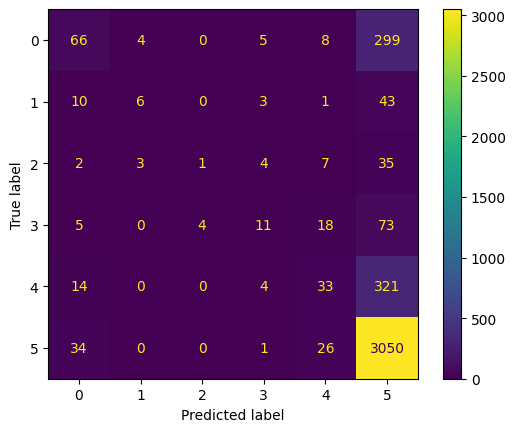

In [27]:
cm_display = ConfusionMatrixDisplay.from_predictions(ytest,y_pred)

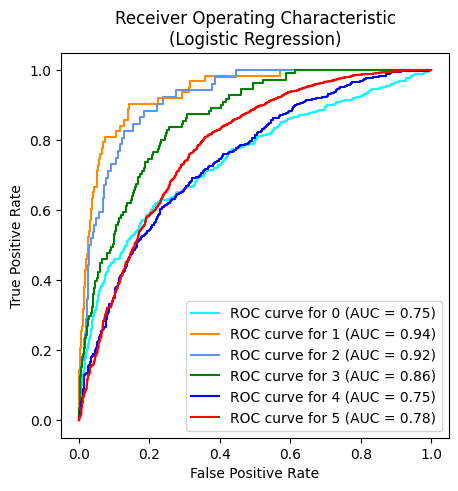

In [28]:
y_scores = log_reg.predict_proba(Xtest_preprocessed)

fig, ax = plt.subplots(figsize=(5,5))
color= ["aqua", "darkorange", "cornflowerblue","green","blue","red"]
for i in range(6):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_scores[:, i],
        name=f"ROC curve for {i}",
        color=color[i],
        ax=ax,
        
    )

_ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Receiver Operating Characteristic\n(Logistic Regression)",
    )

In [29]:
loss = log_loss(ytest,y_scores)
roc_auc = roc_auc_score(ytest,y_scores,multi_class="ovr",average="weighted")
metric_df = pd.concat([pd.DataFrame([['Logistic Regression',accuracy,loss,roc_auc]], columns=metric_df.columns), metric_df], ignore_index=True)

## Support Vector Classifier

In [30]:
svc = SVC(C=1,gamma=0.01, kernel='rbf',probability=True)
# svc.fit(Xtrain_sm,ytrain_sm)

In [31]:
# y_hat = svc.predict(Xtrain_sm)
# print(f'Training Accuracy : {accuracy_score(ytrain_sm,y_hat)}')

# y_pred = svc.predict(Xtest_preprocessed)
# accuracy = accuracy_score(ytest,y_pred)
# print(f'Test Accuracy : {accuracy}')

In [32]:
# param_grid = {'C': [0.1, 1, 10],  
#               'gamma': [0.001, 0.01, 0.1], 
#               'kernel': ['linear', 'rbf']}

# svc_grid_search = GridSearchCV( svc,
#                                 param_grid=param_grid,
#                                 cv=5,
#                                 scoring="accuracy",
#                                 return_train_score=True,
#                                 n_jobs=-1)
# svc_grid_search.fit(Xtrain_sm,ytrain_sm)

# svc_grid_search.best_params_
# {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [33]:
# print(classification_report(ytest,y_pred))

In [34]:
# cm_display = ConfusionMatrixDisplay.from_predictions(ytest,y_pred)

In [35]:
# y_scores = svc.predict_proba(Xtest_preprocessed)

# fig, ax = plt.subplots(figsize=(5,5))
# color= ["aqua", "darkorange", "cornflowerblue","green","blue","red"]
# for i in range(6):
#     RocCurveDisplay.from_predictions(
#         y_onehot_test[:, i],
#         y_scores[:, i],
#         name=f"ROC curve for {i}",
#         color=color[i],
#         ax=ax,
        
#     )

# _ = ax.set(
#         xlabel="False Positive Rate",
#         ylabel="True Positive Rate",
#         title=f"Receiver Operating Characteristic\n(SVC)"
# )

In [36]:
# loss = log_loss(ytest,y_scores)
# roc_auc = roc_auc_score(ytest,y_scores,multi_class="ovr",average="weighted")
# metric_df = pd.concat([pd.DataFrame([['SVC',accuracy,loss,roc_auc]], columns=metric_df.columns), metric_df], ignore_index=True)

## Random Forest Classifier

In [37]:
rfc = RandomForestClassifier(n_estimators=100,criterion="gini", max_depth=None, max_features='sqrt', max_leaf_nodes=None, bootstrap=True)
rfc.fit(Xtrain_sm,ytrain_sm)

RandomForestClassifier()

In [38]:
y_hat = rfc.predict(Xtrain_sm)
print(f'Training Accuracy : {accuracy_score(ytrain_sm,y_hat)}')

y_pred = rfc.predict(Xtest_preprocessed)
accuracy = accuracy_score(ytest,y_pred)
print(f'Test Accuracy : {accuracy}')

Training Accuracy : 0.9994760557476684
Test Accuracy : 0.7714495233439257


In [39]:
param_grid = { 
    'n_estimators': [50, 100, 150],
    'criterion': ['gini','entropy','log_loss'],
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [1,3,None], 
    'max_leaf_nodes': [1,3,None], 
}
rfc_grid_search = GridSearchCV( rfc,
                                param_grid=param_grid,
                                cv=5,
                                scoring="accuracy",
                                return_train_score=True,
                                n_jobs=-1)
# rfc_grid_search.fit(Xtrain_sm,ytrain_sm)

# rfc_grid_search.best_params_

# {'criterion': 'gini',
#  'max_depth': None,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': None,
#  'n_estimators': 100}

In [40]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.10      0.18       382
           1       0.33      0.02      0.03        63
           2       0.75      0.06      0.11        52
           3       0.75      0.05      0.10       111
           4       0.64      0.04      0.07       372
           5       0.77      0.99      0.87      3111

    accuracy                           0.77      4091
   macro avg       0.65      0.21      0.23      4091
weighted avg       0.74      0.77      0.69      4091



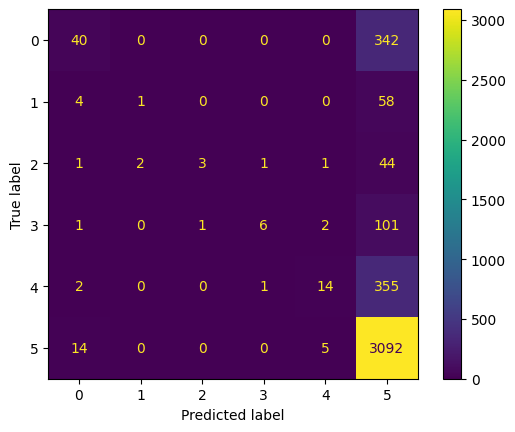

In [41]:
cm_display = ConfusionMatrixDisplay.from_predictions(ytest,y_pred)

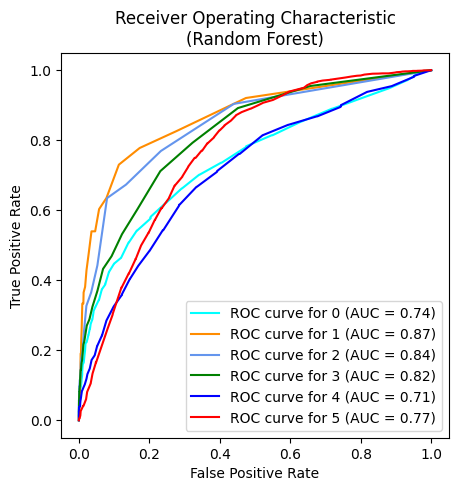

In [42]:
y_scores = rfc.predict_proba(Xtest_preprocessed)

fig, ax = plt.subplots(figsize=(5,5))
color= ["aqua", "darkorange", "cornflowerblue","green","blue","red"]
for i in range(6):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_scores[:, i],
        name=f"ROC curve for {i}",
        color=color[i],
        ax=ax,
        
    )

_ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Receiver Operating Characteristic\n(Random Forest)"
)

In [43]:
loss = log_loss(ytest,y_scores)
roc_auc = roc_auc_score(ytest,y_scores,multi_class="ovr",average="weighted")
metric_df = pd.concat([pd.DataFrame([['RandomForest',accuracy,loss,roc_auc]], columns=metric_df.columns), metric_df], ignore_index=True)

## XGBoost Classifier

In [44]:
xgbc = XGBClassifier(n_estimators=150,booster="gbtree", learning_rate=0.01,subsample=0.9, objective='multi:softmax',tree_method="hist",random_state=42)
# xgbc.fit(Xtrain_sm,ytrain_sm)

In [45]:
# y_hat = xgbc.predict(Xtrain_sm)
# print(f'Training Accuracy : {accuracy_score(ytrain_sm,y_hat)}')

# y_pred = xgbc.predict(Xtest_preprocessed)
# accuracy = accuracy_score(ytest,y_pred)
# print(f'Test Accuracy : {accuracy}')

In [46]:
# param_grid ={'learning_rate': [0.001,0.01,0.1],
#              'subsample' : [0.8,0.9,1],
#              'n_estimator' : [100,150,200]
#             }
# xgbc_grid_search = GridSearchCV( xgbc,
#                                 param_grid=param_grid,
#                                 cv=5,
#                                 scoring="accuracy",
#                                 return_train_score=True,
#                                 n_jobs=-1)
# xgbc_grid_search.fit(Xtrain,ytrain)

# xgbc_grid_search.best_params_
# {'learning_rate': 0.01, 'n_estimator': 150, 'subsample': 0.9}

In [47]:
# print(classification_report(ytest,y_pred))

In [48]:
# cm_display = ConfusionMatrixDisplay.from_predictions(ytest,y_pred)

In [49]:
# y_scores = xgbc.predict_proba(Xtest_preprocessed)

# fig, ax = plt.subplots(figsize=(5,5))
# color= ["aqua", "darkorange", "cornflowerblue","green","blue","red"]
# for i in range(6):
#     RocCurveDisplay.from_predictions(
#         y_onehot_test[:, i],
#         y_scores[:, i],
#         name=f"ROC curve for {i}",
#         color=color[i],
#         ax=ax,
        
#     )

# _ = ax.set(
#         xlabel="False Positive Rate",
#         ylabel="True Positive Rate",
#         title=f"Receiver Operating Characteristic\n(XGBoost)"
# )

In [50]:
# loss = log_loss(ytest,y_scores)
# roc_auc = roc_auc_score(ytest,y_scores,multi_class="ovr",average="weighted")
# metric_df = pd.concat([pd.DataFrame([['XGBoostClf',accuracy,loss,roc_auc]], columns=metric_df.columns), metric_df], ignore_index=True)

## LightGBM Classifier

In [51]:
lgbm = LGBMClassifier(boosting_type="dart", n_estimators = 200, learning_rate=0.3, subsample=0.9,num_leaves=31,is_unbalance=True, n_jobs=-1, random_state=42)
lgbm.fit(Xtrain_sm,ytrain_sm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56526
[LightGBM] [Info] Number of data points in the train set: 9543, number of used features: 1069
[LightGBM] [Info] Start training from score -2.372342
[LightGBM] [Info] Start training from score -4.173131
[LightGBM] [Info] Start training from score -4.359542
[LightGBM] [Info] Start training from score -3.614487
[LightGBM] [Info] Start training from score -2.396220
[LightGBM] [Info] Start training from score -0.273704


LGBMClassifier(boosting_type='dart', is_unbalance=True, learning_rate=0.3,
               n_estimators=200, n_jobs=-1, random_state=42, subsample=0.9)

In [52]:
y_hat = lgbm.predict(Xtrain_sm)
print(f'Training Accuracy : {accuracy_score(ytrain_sm,y_hat)}')

y_pred = lgbm.predict(Xtest_preprocessed)
accuracy = accuracy_score(ytest,y_pred)
print(f'Test Accuracy : {accuracy}')

Training Accuracy : 0.9859582940375144
Test Accuracy : 0.7836714739672451


In [53]:
param_grid = {'n_estimator' : [150,200,250],
             'learning_rate': [0.2,0.3,0.4],
              'subsample': [0.8,0.9,1],
             'num_leaves':[31,50,80]}

lgbm_grid_search = GridSearchCV( lgbm,
                                param_grid=param_grid,
                                cv=5,
                                scoring="accuracy",
                                return_train_score=True,
                                n_jobs=-1)
# lgbm_grid_search.fit(Xtrain,ytrain)
# lgbm_grid_search.best_params_
# {'learning_rate': 0.3, 'n_estimator': 200, 'num_leaves': 31, 'subsample': 0.9}

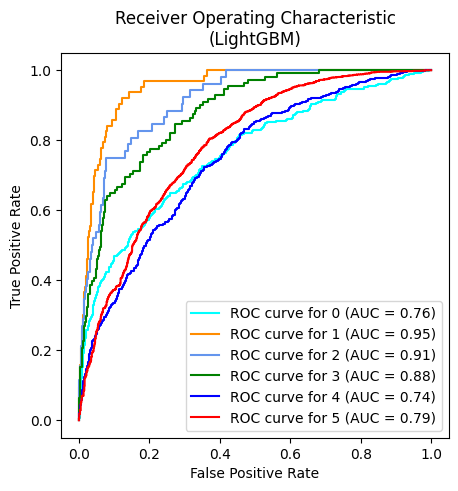

In [54]:
y_scores = lgbm.predict_proba(Xtest_preprocessed)

fig, ax = plt.subplots(figsize=(5,5))
color= ["aqua", "darkorange", "cornflowerblue","green","blue","red"]
for i in range(6):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_scores[:, i],
        name=f"ROC curve for {i}",
        color=color[i],
        ax=ax,
        
    )

_ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Receiver Operating Characteristic\n(LightGBM)"
)

In [55]:
loss = log_loss(ytest,y_scores)
roc_auc = roc_auc_score(ytest,y_scores,multi_class="ovr",average="weighted")
metric_df = pd.concat([pd.DataFrame([['LightBGM',accuracy,loss,roc_auc]], columns=metric_df.columns), metric_df], ignore_index=True)

# Model Comparision

In [56]:
metric_df

,Model,Accuracy,Log_loss,ROC_AUC_Score
0,LightBGM,0.783671,0.779932,0.786101
1,RandomForest,0.771450,0.891811,0.766141
2,Logistic Regression,0.774138,0.709250,0.782093


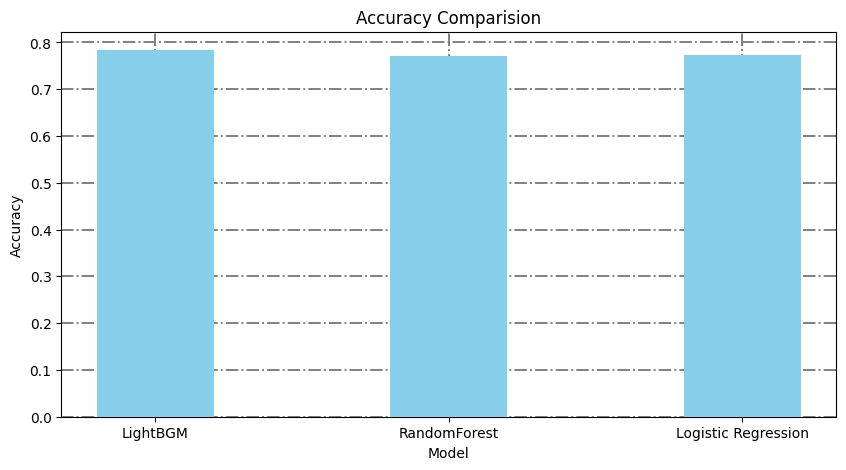

In [57]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(metric_df.Model, metric_df.Accuracy, color ='skyblue', 
        width = 0.4,zorder=3)
 
plt.xlabel("Model")
plt.ylabel("Accuracy")
# plt.yticks(np.arange(0,1.1,0.1))
plt.title("Accuracy Comparision")
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.show()

```LightBGM``` comes out to the best model in terms of accurary.

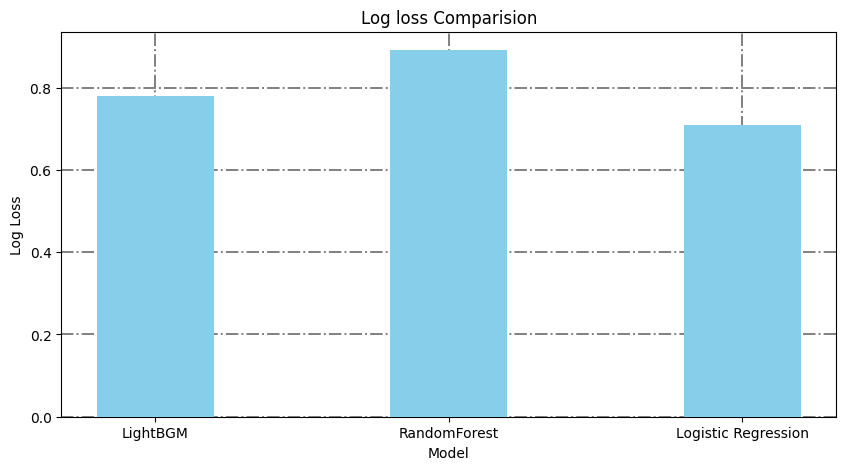

In [58]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(metric_df.Model, metric_df.Log_loss, color ='skyblue', 
        width = 0.4,zorder=3)
 
plt.xlabel("Model")
plt.ylabel("Log Loss")
plt.title("Log loss Comparision")
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.show()

```Logistic Regressing``` performs best in term of log_loss.

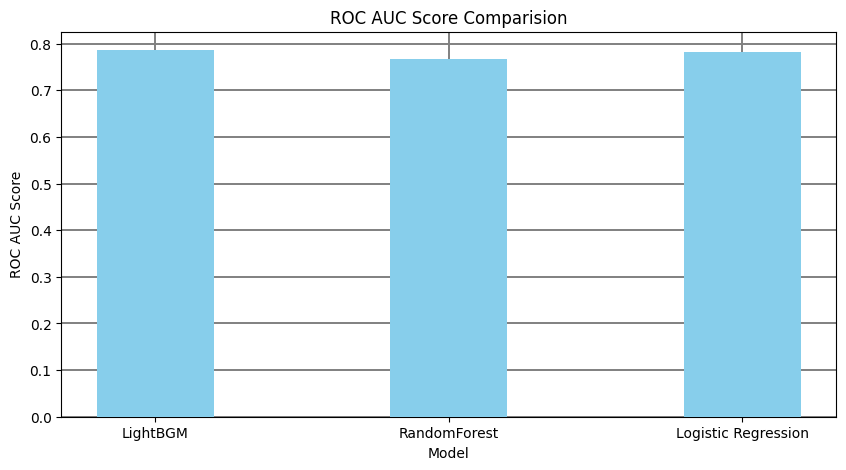

In [59]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(metric_df.Model, metric_df.ROC_AUC_Score, color ='skyblue', 
        width = 0.4,zorder=3)
 
plt.xlabel("Model")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Score Comparision")
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "-")
plt.show()

```LightGBM``` performs best in terms of ROC AUC score.

Hence ```LightBGM``` is the best model among the trained model. Hence, we will select ```LightBGM``` to make predictions for the test data.

# Training Best Model with entire Train.csv

Since we have got our best model, we will now train our best model using entire training data. This will help the model to perform better on test data.

In [60]:
best_model = lgbm
features = preprocessing.transform(features)
best_model.fit(features,label)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72208
[LightGBM] [Info] Number of data points in the train set: 13634, number of used features: 1069
[LightGBM] [Info] Start training from score -2.371976
[LightGBM] [Info] Start training from score -4.173214
[LightGBM] [Info] Start training from score -4.361267
[LightGBM] [Info] Start training from score -3.612239
[LightGBM] [Info] Start training from score -2.396649
[LightGBM] [Info] Start training from score -0.273746


LGBMClassifier(boosting_type='dart', is_unbalance=True, learning_rate=0.3,
               n_estimators=200, n_jobs=-1, random_state=42, subsample=0.9)

# Prediction Time

## Reading Test.csv

In [61]:
test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


## Making Predictions

In [63]:
test = preprocessing.transform(test)
prediction = best_model.predict(test)

## Sample Output File

In [64]:
sample = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv")
sample.head()

,ID,Rating
0,1,5
1,2,2
2,3,4
3,4,2
4,5,4


## Creating Submission File

In [65]:
submission = pd.DataFrame(columns = ["ID", "Rating"])
submission["ID"] = [i+1 for i in range(len(prediction))]
submission["Rating"] = prediction

In [66]:
submission.to_csv("submission.csv", index=False)

In [67]:
submission.head()

,ID,Rating
0,1,5
1,2,5
2,3,0
3,4,3
4,5,5
